In [ ]:
import string

import re

from numpy import array, argmax, random, take

import pandas as pd

from keras.models import Sequential

from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed

from keras.preprocessing.text import Tokenizer

from keras.callbacks import ModelCheckpoint

from keras.preprocessing.sequence import pad_sequences

from keras.models import load_model

from keras import optimizers

import matplotlib.pyplot as plt 

% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Read Data Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

function to read raw text file

In [ ]:
#function to read raw text file

def read_text(filename):

#open the file 
  file = open(filename , mode='rt', encoding="utf-8")

#read all text

  text = file.read()

  file.close()

  return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [ ]:
#splat text into sentonce

def to_lines (text):
  sents = text.strip().split('\n')

  sents = [i.split('\t') for i in sents]

  return sents



Download the data from here. and extract "deu.txt" in your working directory.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data= read_text("/content/gdrive/My Drive/NLP Project/INTRENSHIP PROJCT/deu.txt")

deu_eng= to_lines (data) 
deu_eng= array(deu_eng)
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
        'Es ist wohl unmöglich, einen vollkommen fehlerfreien Korpus zu erreichen\xa0— das liegt in der Natur eines solchen Gemeinschaftsprojekts. Doch wenn wir unsere Mitglieder dazu bringen können, nicht mit Sprachen herumzuexperimentieren, die sie gerade lernen, sondern Sätze in ihrer eigenen Muttersprache beizutragen, dann gelingt 

Text to Sequence Conversion
To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [ ]:
eng_l=[]
deu_l = []

for i in deu_eng[:,0]: 
  eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))



In [ ]:
length_df = pd.DataFrame({'eng':eng_l, 'deu': deu_l})

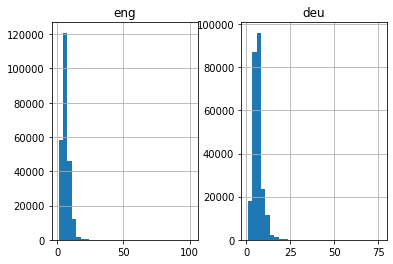

In [ ]:
length_df.hist(bins = 30) 
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [ ]:
def tokenization (lines):
     tokenizer = Tokenizer()
     tokenizer.fit_on_texts(lines) 
     return tokenizer

In [ ]:
eng_tokenizer = tokenization (deu_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 16902


In [ ]:
# prepare Deutch tokenizer

deu_tokenizer = tokenization (deu_eng[:, 1])

deu_vocab_size = len(deu_tokenizer.word_index) +1

deu_length = 8 
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 36927


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.

In [ ]:
# encode and pad sequences

def encode_sequences (tokenizer, length, lines): 
    
    # integer encode sequences 
    seq= tokenizer.texts_to_sequences (lines) 
    # # pad sequences with 0 values

    seq= pad_sequences (seq, maxlen=length, padding='post')
    return seq 

Model Building
We will now split the data into train and test set for model training and evaluation, respectively.

In [ ]:
from sklearn.model_selection import train_test_split 
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [ ]:
 # prepare training data

trainX = encode_sequences (deu_tokenizer, deu_length, train[:, 1])
trainy = encode_sequences (eng_tokenizer, eng_length, train[:, 0])


In [ ]:
   # prepare validation data

testx= encode_sequences (deu_tokenizer, deu_length, test[:, 1])

testy = encode_sequences (eng_tokenizer, eng_length, test[:, 0])
             

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.


In [ ]:
#build NMT model

def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
   model = Sequential()
   model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
   model.add(LSTM(units))
   model.add(RepeatVector(out_timesteps))
   model.add(LSTM(units, return_sequences=True))
   model.add(Dense(out_vocab, activation='softmax'))
   return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [ ]:
 from tensorflow.keras import optimizers

In [ ]:
model= build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512) 
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Please note that we have used 'sparse_categorical_crossentropy' as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using ModelCheckpoint() to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [ ]:
filename = 'model.h1.24_ritesh'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history=model.fit(trainX, trainy.reshape(trainy.shape[0], trainy.shape[1], 1), 
epochs=2, batch_size=512,
validation_split = 0.2,
callbacks=[checkpoint], verbose=1)

Epoch 1/2
301/301 [==============================] - ETA: 0s - loss: 3.5885
Epoch 1: val_loss improved from inf to 3.40128, saving model to model.h1.24_ritesh


INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets


INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets


301/301 [==============================] - 2199s 7s/step - loss: 3.5885 - val_loss: 3.4013
Epoch 2/2
301/301 [==============================] - ETA: 0s - loss: 3.1546
Epoch 2: val_loss improved from 3.40128 to 3.11062, saving model to model.h1.24_ritesh


INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets


INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets


301/301 [==============================] - 2171s 7s/step - loss: 3.1546 - val_loss: 3.1106


In [ ]:
filename = 'model.h1.24_ritesh'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history=model.fit(trainX, trainy.reshape(trainy.shape[0], trainy.shape[1], 1), 
epochs=5, batch_size=512,
validation_split = 0.2,
callbacks=[checkpoint], verbose=1)

301/301 [==============================] - ETA: 0s - loss: 4.7211
Epoch 1: val_loss improved from inf to 4.34562, saving model to model.h1.24_ritesh


INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets


INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets


301/301 [==============================] - 2078s 7s/step - loss: 4.7211 - val_loss: 4.3456


301/301 [==============================] - ETA: 0s - loss: 4.7211
Epoch 1: val_loss improved from inf to 4.34562, saving model to model.h1.24_ritesh
WARNING:absl:Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets
INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets
WARNING:absl:<keras.layers.recurrent.LSTMCell object at 0x7f10eb039550> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
WARNING:absl:<keras.layers.recurrent.LSTMCell object at 0x7f10ea6db2d0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
301/301 [==============================] - 2078s 7s/step - loss: 4.7211 - val_loss: 4.3456

301/301 [==============================] - ETA: 0s - loss: 4.7211
Epoch 1: val_loss improved from inf to 4.34562, saving model to model.h1.24_ritesh
WARNING:absl:Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets
INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets
WARNING:absl:<keras.layers.recurrent.LSTMCell object at 0x7f10eb039550> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
WARNING:absl:<keras.layers.recurrent.LSTMCell object at 0x7f10ea6db2d0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
301/301 [==============================] - 2078s 7s/step - loss: 4.7211 - val_loss: 4.3456

301/301 [==============================] - ETA: 0s - loss: 4.7211
Epoch 1: val_loss improved from inf to 4.34562, saving model to model.h1.24_ritesh
WARNING:absl:Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets
INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets
WARNING:absl:<keras.layers.recurrent.LSTMCell object at 0x7f10eb039550> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
WARNING:absl:<keras.layers.recurrent.LSTMCell object at 0x7f10ea6db2d0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
301/301 [==============================] - 2078s 7s/step - loss: 4.7211 - val_loss: 4.3456

301/301 [==============================] - ETA: 0s - loss: 4.7211
Epoch 1: val_loss improved from inf to 4.34562, saving model to model.h1.24_ritesh
WARNING:absl:Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets
INFO:tensorflow:Assets written to: model.h1.24_ritesh/assets
WARNING:absl:<keras.layers.recurrent.LSTMCell object at 0x7f10eb039550> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
WARNING:absl:<keras.layers.recurrent.LSTMCell object at 0x7f10ea6db2d0> has the same name 'LSTMCell' as a built-in Keras object. Consider renaming <class 'keras.layers.recurrent.LSTMCell'> to avoid naming conflicts when loading with `tf.keras.models.load_model`. If renaming is not possible, pass the object in the `custom_objects` parameter of the load function.
301/301 [==============================] - 2078s 7s/step - loss: 4.7211 - val_loss: 4.3456

In [ ]:
filename = 'model.h1.24_ritesh'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history=model.fit(trainX, trainy.reshape(trainy.shape[0], trainy.shape[1], 1), 
epochs=1, batch_size=15512,
validation_split = 0.2,
callbacks=[checkpoint], verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.legend(['train', 'validation']) 
plt.show()


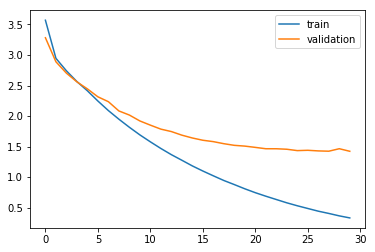

Make Predictions
Let's load the saved model to make predictions

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
model = load_model('model.h1.24_ritesh')
preds=model.predict(testx.reshape((testx.shape [0], testx.shape[1])))

In [ ]:
def get word(n, tokenizer):
for word, index in tokenizer.word_index.items():
if index== n:
return word
return None

In [ ]:
# convert predictions into text (English) 
preds_text=[]
for i in preds:
temp = []
for j in range(len(i)):
t = get_word (1[j], eng_tokenizer) 
if j> 0:
if (t = get_word (i[J-1], eng_tokenizer)) or (t == None):
     temp.append('')
     else:
temp.append(t)
else:
if(t == None):
temp.append('')
else:
    temp.append(t)
preds_text.append(''.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual': test[:,0], 'predicted': preds_text})


In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)


           actual           	predicted
0	weve run out of gas	      we ran out of gas
1	its a fad	                its a fad
2	tom was shaken            tom was shaken
3	this annoys me	          this annoys me
4	let me do that for you	  let me do you
5	you will pay for this	    youll pay for this
6	tom often cuts classes	  tom often cut classes
7	hes young and healthy 	  he is young and healthy
8	life is enjoyable	life    is beautiful
9	i know it sounds silly  	i know it sounds silly
10	i raise cattle	        im going to
11	dont worry	            dont be worried
12	close the door	        shut the door
13	youre joking	          youre kidding
14	tom seemed lucky      	tom seemed lucky

In [ ]:
pred_df.tail(15)

	           actual	               predicted
9985	tom knew the risks	        tom knew the risks
9986	what does she do	          what does she do
9987	she still loved him	        she still loved him 
9988	i want to be careful     	  i want to be boston
9989	im here arent              	im here arent
9990	youre a hypocrite	          youre a hypocrite
9991	i gave you a book	          i gave you a book
9992	lets do it                  lets do it
9993	i broke my leg skiing       i broke my leg skiing
9994	i was victorious	          i was been asleep
9995	what a pretty               woman	what a wife
9996	well come with you          were come with you
9997	i am the same age	          im am the same age
9998	who should we believe       who do we going
9999	whats it good for	          whats it good for